# Setting the stage for Project 1

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

baseball2017 = pd.read_csv("play_by_play_2017.csv")
baseball2018 = pd.read_csv("play_by_play_2018.csv")
baseball2019 = pd.read_csv("play_by_play_2019.csv")
baseball2020 = pd.read_csv("play_by_play_2020.csv")

In [4]:
baseball2020.head()


,Inning,Score,Outs,RoB,Pitches..Count.,Pitch.Sequence,Run.Out.No.Out,Team,Batter,Pitcher,WPA,WE,Play.Description,Game.ID,HBP,Season
0,t1,0-0,0,---,1(0-0),X,nO,SFG,Mike Yastrzemski,Dustin May,-4%,46%,Reached on E6 (Ground Ball to Deep SS); Yastrz...,LAN202007230,0,2020
1,t1,0-0,0,1--,3(0-2),CSX,O,SFG,Wilmer Flores,Dustin May,3%,50%,Flyball: RF (RF Line),LAN202007230,0,2020
2,t1,0-0,1,1--,2(0-1),CX,O,SFG,Pablo Sandoval,Dustin May,3%,53%,Single to 3B/runner struck by batted ball and ...,LAN202007230,0,2020
3,t1,0-0,2,1--,4(2-1),BBSX,nO,SFG,Alex Dickerson,Dustin May,-2%,51%,Single to SS (Ground Ball); Sandoval to 2B,LAN202007230,0,2020
4,t1,0-0,2,12-,2(0-1),CX,O,SFG,Hunter Pence,Dustin May,4%,55%,Groundout: P-1B (Front of Home),LAN202007230,0,2020


In [5]:
baseball = pd.concat([baseball2017, baseball2018, baseball2019, baseball2020], ignore_index=True)


In [6]:
bclutch = baseball[~baseball["Inning"].isin(["b1", "t1", "t2", "b2", "b3", "t3", "t4", "b4", "b5", "t5", "t6", "b6"])]

bclutch = bclutch.copy()

# Turn WPA into string
wpa_str = bclutch["WPA"].astype("string").str.strip()

# Create WPA_num column with correct dtype
bclutch["WPA_num"] = pd.Series([pd.NA] * len(bclutch), dtype="Float64")

# Identify rows with percent signs
has_percent = wpa_str.str.endswith("%")

# Convert rows WITH "%" to decimal
bclutch.loc[has_percent, "WPA_num"] = (
    wpa_str[has_percent]
    .str.rstrip("%")
    .astype("Float64") / 100)

# Convert rows WITHOUT "%"
bclutch.loc[~has_percent, "WPA_num"] = pd.to_numeric(
    wpa_str[~has_percent], errors="coerce"
).astype("Float64")

# Create absolute value column
bclutch["WPA_abs"] = bclutch["WPA_num"].abs()

In [7]:
bclutch.head()

,Inning,Score,Outs,RoB,Pitches..Count.,Pitch.Sequence,Run.Out.No.Out,Team,Batter,Pitcher,WPA,WE,Play.Description,Game.ID,HBP,Season,WPA_num,WPA_abs
50,t7,3-3,0,---,3(0-2),.CFX,O,SFG,Joe Panik,Andrew Chafin,4%,54%,Groundout: SS-1B,ARI201704020,0,2017,0.04,0.04
51,t7,3-3,1,---,3(2-0),BBX,R,SFG,Madison Bumgarner,Andrew Chafin,-19%,35%,Home Run (Fly Ball to Deep LF Line),ARI201704020,0,2017,-0.19,0.19
52,t7,4-3,1,---,6(2-2),BSBFFX,nO,SFG,Denard Span,Andrew Chafin,-3%,32%,Single to 2B (Ground Ball),ARI201704020,0,2017,-0.03,0.03
53,t7,4-3,1,1--,2(1-1),BS111,O,SFG,Brandon Belt,Andrew Chafin,5%,37%,Span Caught Stealing (PO) 2B (P-1B),ARI201704020,0,2017,0.05,0.05
54,t7,4-3,2,---,4(2-1),BS111.BX,O,SFG,Brandon Belt,Andrew Chafin,1%,38%,Groundout: 2B-1B,ARI201704020,0,2017,0.01,0.01


In [8]:
bclutch = bclutch.copy().reset_index(drop=True)

#separates the score by "-"
nums = bclutch['Score'].astype(str).str.extract(r'(\d+)\s*-\s*(\d+)', expand=True)
nums = nums.apply(pd.to_numeric, errors='coerce')

#keeps games only within 4 runs
bclutch[['batting_score','defending_score']] = nums
bclutch['score_diff'] = bclutch['batting_score'] - bclutch['defending_score']
bclutch = bclutch[(bclutch['score_diff'] <= 0) & (bclutch['score_diff'] > -5)]

In [9]:
#keeps game states where offense can tie or take lead
keep_patterns  = ["--3", "-2-", "1--"]
keep_patterns2 = ["12-", "-23", "1-3"]
keep_patterns3 = ["123"]
keep_patterns4 = ["---"]

bclutch = bclutch[
    (
        (bclutch["RoB"].isin(keep_patterns)) &
        (bclutch["score_diff"] >= -2)
    )
    |
    (
        (bclutch["RoB"].isin(keep_patterns2)) &
        (bclutch["score_diff"] >= -3)
    )
    |
    (
        (bclutch["RoB"].isin(keep_patterns3)) &
        (bclutch["score_diff"] >= -4)
    )
    |
    (
        (bclutch["RoB"].isin(keep_patterns4)) &
        (bclutch["score_diff"] >= -1)
    )]

In [10]:
#getting our weights by isolating run scoring hits
bclutch_runs = bclutch[bclutch["Run.Out.No.Out"].str.contains("R", na=False)]
bclutch_runs = bclutch_runs[bclutch_runs["Pitch.Sequence"].str.contains("X", na=False)]
bclutch_runs.head()

,Inning,Score,Outs,RoB,Pitches..Count.,Pitch.Sequence,Run.Out.No.Out,Team,Batter,Pitcher,...,WE,Play.Description,Game.ID,HBP,Season,WPA_num,WPA_abs,batting_score,defending_score,score_diff
1,t7,3-3,1,---,3(2-0),BBX,R,SFG,Madison Bumgarner,Andrew Chafin,...,35%,Home Run (Fly Ball to Deep LF Line),ARI201704020,0,2017,-0.19,0.19,3,3,0
17,b8,3-4,0,12-,5(2-2),CCBBX,R,ARI,Paul Goldschmidt,Derek Law,...,77%,Single to LF (Ground Ball thru SS-3B Hole); Po...,ARI201704020,0,2017,0.21,0.21,3,4,-1
21,t9,4-4,0,--3,2(1-0),.BX,RO,SFG,Conor Gillaspie,Fernando Rodney,...,20%,Lineout: CF/Sacrifice Fly (Deep CF-RF); Panik ...,ARI201704020,0,2017,-0.03,0.03,4,4,0
32,b9,4-5,2,-2-,2(0-1),..CX,R,ARI,Daniel Descalso,Mark Melancon,...,57%,Single to CF (Line Drive to CF-RF); Hazelbaker...,ARI201704020,0,2017,0.42,0.42,4,5,-1
35,b9,5-5,2,-23,4(1-2),>C.C*BX,R,ARI,Chris Owings,Mark Melancon,...,100%,Single to RF (Line Drive); Descalso Scores; Po...,ARI201704020,0,2017,0.36,0.36,5,5,0


In [11]:
#separated by inning
wp7th = bclutch_runs["Inning"].isin(["b7", "t7"])
wp8th = bclutch_runs["Inning"].isin(["b8", "t8"])
wp9th = bclutch_runs["Inning"].isin(["b9", "t9"])
wpextra = ~bclutch_runs["Inning"].isin(["b7", "t7", "b8", "t8", "b9", "t9"])

In [12]:
#finnally we get our average values
avg_wpa7 = bclutch_runs.loc[wp7th, "WPA_abs"].mean()
print("Average WPA_abs (7th inning):", avg_wpa7)
avg_wpa8 = bclutch_runs.loc[wp8th, "WPA_abs"].mean()
print("Average WPA_abs (8th inning):", avg_wpa8)
avg_wpa9 = bclutch_runs.loc[wp9th, "WPA_abs"].mean()
print("Average WPA_abs (9th inning):", avg_wpa9)
avg_wpaextra = bclutch_runs.loc[wpextra, "WPA_abs"].mean()
print("Average WPA_abs (Extra innings):", avg_wpaextra)
#can easily normalize these by hand

Average WPA_abs (7th inning): 0.1903749330476701
Average WPA_abs (8th inning): 0.23209812782440284
Average WPA_abs (9th inning): 0.29824689554419287
Average WPA_abs (Extra innings): 0.3047965474722565


In [13]:
bclutch["Pitch.Sequence"].astype(str).str[-1].value_counts()

Pitch.Sequence
X    38410
S    11532
B     7094
C     3381
T      905
V      793
H      699
1      119
N       71
2       24
F       24
L       24
M       14
P        8
3        8
.        8
n        5
Name: count, dtype: int64

In [14]:
#isolating at-bats vs plate appearances (at-bats dont include walks)
bclutch[bclutch["Pitch.Sequence"].astype(str).str[-1] == "B"].head()

,Inning,Score,Outs,RoB,Pitches..Count.,Pitch.Sequence,Run.Out.No.Out,Team,Batter,Pitcher,...,WE,Play.Description,Game.ID,HBP,Season,WPA_num,WPA_abs,batting_score,defending_score,score_diff
67,b9,3-3,2,12-,6(3-2),BBBCF*B,nO,STL,Kolten Wong,Mike Montgomery,...,66%,Walk; Martinez to 3B; Molina to 2B,SLN201704020,0,2017,0.05,0.05,3,3,0
104,t8,2-2,0,---,7(3-2),..CBSBFBB,nO,TOR,Russell Martin,Brad Brach,...,43%,Walk,BAL201704030,0,2017,-0.07,0.07,2,2,0
120,t10,2-2,2,---,6(3-2),FBSBBB,nO,TOR,Russell Martin,Zach Britton,...,57%,Walk,BAL201704030,0,2017,-0.03,0.03,2,2,0
139,t7,2-5,1,12-,3(1-1),BCB,nO,PIT,Adam Frazier,Matt Barnes,...,79%,Wild Pitch; Harrison to 3B; Mercer to 2B,BOS201704030,0,2017,-0.04,0.04,2,5,-3
140,t7,2-5,1,-23,5(3-1),BCB.BB,nO,PIT,Adam Frazier,Matt Barnes,...,76%,Walk,BOS201704030,0,2017,-0.03,0.03,2,5,-3


In [15]:
#this is for wOBA later
ball = bclutch

#keeping only at-bats
bclutch = bclutch[
    (bclutch["Pitch.Sequence"].astype(str).str[-1].isin(["X", "L"])) |
    (bclutch["Play.Description"].str.contains("Strikeout", na=False))]
bclutch = bclutch[~bclutch["Play.Description"].str.contains("Reached", na=False)]

In [16]:
#total clutch at-bats
len(bclutch)

53167

In [17]:
#list all outcomes of at-bat
bclutch["Run.Out.No.Out"].value_counts()

Run.Out.No.Out
O       38513
nO       7702
R        3259
OO       1443
RR       1054
RO        747
RRR       305
RRRR       77
ROO        37
RRO        30
Name: count, dtype: int64

In [18]:
#separate by success and failiure
b_nosuccess = bclutch[
    (bclutch["Run.Out.No.Out"].astype(str) == "OO") |
    (bclutch["Run.Out.No.Out"].astype(str) == "O")]

In [19]:
b_success = bclutch[
    (bclutch["Run.Out.No.Out"].astype(str) == "nO") |
    (bclutch["Run.Out.No.Out"].astype(str) == "R")|
    (bclutch["Run.Out.No.Out"].astype(str) == "RR")|
    (bclutch["Run.Out.No.Out"].astype(str) == "RO")|
    (bclutch["Run.Out.No.Out"].astype(str) == "RRR")|
    (bclutch["Run.Out.No.Out"].astype(str) == "RRRR")|
    (bclutch["Run.Out.No.Out"].astype(str) == "ROO")|
    (bclutch["Run.Out.No.Out"].astype(str) == "RRO")]

In [20]:
# filtered by inning for success
b_success7th = b_success[b_success["Inning"].isin(["b7", "t7"])]
b_success8th = b_success[b_success["Inning"].isin(["b8", "t8"])]
b_success9th = b_success[b_success["Inning"].isin(["b9", "t9"])]
b_successextra = b_success[~b_success["Inning"].isin(["b7", "t7", "b8", "t8", "b9", "t9"])]

In [21]:
#now finding each players batting average per inning
success7th = b_success7th.groupby("Batter").size()
attempts7th = bclutch[bclutch["Inning"].isin(["b7", "t7"])].groupby("Batter").size()
success_rate7th = (success7th / attempts7th).fillna(0)

success8th = b_success8th.groupby("Batter").size()
attempts8th = bclutch[bclutch["Inning"].isin(["b8", "t8"])].groupby("Batter").size()
success_rate8th = (success8th / attempts8th).fillna(0)

success9th = b_success9th.groupby("Batter").size()
attempts9th = bclutch[bclutch["Inning"].isin(["b9", "t9"])].groupby("Batter").size()
success_rate9th = (success9th / attempts9th).fillna(0)

successextra = b_successextra.groupby("Batter").size()
attemptsextra = bclutch[~bclutch["Inning"].isin(["b7", "t7","b8", "t8","b9", "t9"])].groupby("Batter").size()
success_rateextra = (successextra / attemptsextra).fillna(0)

In [22]:
#merge the inning BA
clutchBA = pd.DataFrame({
    "7th BA": success_rate7th,
    "8th BA": success_rate8th,
    "9th BA": success_rate9th,
    "Extras BA": success_rateextra})

In [23]:
#multiplying each BA by our found weights
clutchBA["Clutch"] = (
    clutchBA["7th BA"] * 0.1856 +
    clutchBA["8th BA"] * 0.2263 +
    clutchBA["9th BA"] * 0.2908 +
    clutchBA["Extras BA"] * 0.2972)

In [24]:
#setting up the rest of the table to double check if needed
attempts7th = bclutch[bclutch["Inning"].isin(["b7", "t7"])].groupby("Batter").size()
attempts8th = bclutch[bclutch["Inning"].isin(["b8", "t8"])].groupby("Batter").size()
attempts9th = bclutch[bclutch["Inning"].isin(["b9", "t9"])].groupby("Batter").size()
attemptsextra = bclutch[~bclutch["Inning"].isin(["b7", "t7", "b8", "t8", "b9", "t9"])].groupby("Batter").size()
clutchBA["attempts7th"] = attempts7th
clutchBA["attempts8th"] = attempts8th
clutchBA["attempts9th"] = attempts9th
clutchBA["attemptsextra"] = attemptsextra

clutchBA = clutchBA.fillna(0)

In [25]:
clutchBA["total_attempts"] = (
    clutchBA["attempts7th"] +
    clutchBA["attempts8th"] +
    clutchBA["attempts9th"] +
    clutchBA["attemptsextra"])

In [26]:
#finding total rates to help our shrinkage
bclutch["Success"] = ~bclutch["Run.Out.No.Out"].astype(str).isin(["O", "OO"])

batter_counts = bclutch.groupby("Batter")["Success"].agg(
    successes="sum",
    attempts="count"
)
batter_counts["rate"] = batter_counts["successes"] / batter_counts["attempts"]


In [27]:
#empirical bayes shrinkage to get min at-bats (help from Chat-GPT)
mu = batter_counts["rate"].mean()
v = batter_counts["rate"].var()

alpha = mu * ( (mu*(1-mu))/v - 1 )
beta  = (1-mu) * ( (mu*(1-mu))/v - 1 )
batter_counts["EB_rate"] = (
    (batter_counts["successes"] + alpha) /
    (batter_counts["attempts"] + alpha + beta))

batter_counts["shrinkage"] = abs(
    batter_counts["EB_rate"] - batter_counts["rate"])

thr = np.percentile(
    batter_counts["attempts"][batter_counts["shrinkage"] < 0.03],50)
thr

np.float64(66.0)

In [28]:
#filtering our shrinkage
clutchBA1 = clutchBA[clutchBA["total_attempts"] >= 66]

In [29]:
#top 5 clutch
clutchBA1.sort_values("Clutch", ascending=False).head(5)

,7th BA,8th BA,9th BA,Extras BA,Clutch,attempts7th,attempts8th,attempts9th,attemptsextra,total_attempts
Batter,,,,,,,,,,
Melky Cabrera,0.264706,0.440000,0.333333,0.454545,0.380726,34.0,25.0,30.0,11.0,100.0
Justin Turner,0.264706,0.295455,0.341463,0.545455,0.377397,34.0,44.0,41.0,11.0,130.0
Ronald Acuna,0.258065,0.310345,0.300000,0.571429,0.375196,31.0,29.0,20.0,7.0,87.0
Ryan Zimmerman,0.222222,0.333333,0.307692,0.538462,0.366185,18.0,33.0,26.0,13.0,90.0
Ramon Laureano,0.354839,0.200000,0.400000,0.466667,0.366131,31.0,20.0,20.0,15.0,86.0


In [30]:
clutchBA1.loc["Aaron Judge", "Clutch"]

np.float64(0.22269718218324636)

In [31]:
clutchBA1.loc["Neil Walker", "Clutch"]

np.float64(0.3155476190476191)

In [32]:
#now grouping by teams instead of batters
success7th = b_success7th.groupby("Team").size()
attempts7th = bclutch[bclutch["Inning"].isin(["b7", "t7"])].groupby("Team").size()
success_rate7th = (success7th / attempts7th).fillna(0)

success8th = b_success8th.groupby("Team").size()
attempts8th = bclutch[bclutch["Inning"].isin(["b8", "t8"])].groupby("Team").size()
success_rate8th = (success8th / attempts8th).fillna(0)

success9th = b_success9th.groupby("Team").size()
attempts9th = bclutch[bclutch["Inning"].isin(["b9", "t9"])].groupby("Team").size()
success_rate9th = (success9th / attempts9th).fillna(0)

successextra = b_successextra.groupby("Team").size()
attemptsextra = bclutch[~bclutch["Inning"].isin(["b7", "t7","b8", "t8","b9", "t9"])].groupby("Team").size()
success_rateextra = (successextra / attemptsextra).fillna(0)

In [33]:
#merge the same way with weights
clutchBATeam = pd.DataFrame({
    "7th BA": success_rate7th,
    "8th BA": success_rate8th,
    "9th BA": success_rate9th,
    "Extras BA": success_rateextra})
clutchBATeam["Clutch"] = (
    clutchBATeam["7th BA"] * 0.1856 +
    clutchBATeam["8th BA"] * 0.2263 +
    clutchBATeam["9th BA"] * 0.2908 +
    clutchBATeam["Extras BA"] * 0.2972)

In [34]:
#including stadings for future analysis
team_standings = {
    "LAD": 1,
    "HOU": 2,
    "NYY": 3,
    "CLE": 4,
    "BOS": 5,
    "TBR": 6,
    "CHC": 7,
    "OAK": 8,
    "MIN": 9,
    "MIL": 10,
    "WSN": 11,
    "ATL": 12,
    "STL": 13,
    "ARI": 14,
    "COL": 15,
    "SEA": 16,
    "NYM": 17,
    "LAA": 18,
    "PHI": 19,
    "TOR": 20,
    "PIT": 21,
    "TEX": 22,
    "SDP": 23,
    "SFG": 24,
    "CIN": 25,
    "CHW": 26,
    "MIA": 27,
    "KCR": 28,
    "BAL": 29,
    "DET": 30,}

clutchBATeam["Standings"] = clutchBATeam.index.map(team_standings)

#finding the best clutch teams
clutchBATeam.sort_values("Clutch", ascending=False)

,7th BA,8th BA,9th BA,Extras BA,Clutch,Standings
Team,,,,,,
ATL,0.260870,0.265060,0.297297,0.261905,0.272693,12
BOS,0.293249,0.255605,0.270925,0.269663,0.271199,5
HOU,0.294991,0.289954,0.237598,0.250923,0.264035,2
LAD,0.296029,0.234216,0.262931,0.266160,0.263509,1
WSN,0.223320,0.270103,0.236080,0.301980,0.260973,11
NYY,0.269311,0.255274,0.263033,0.254682,0.259934,3
OAK,0.248188,0.277890,0.254545,0.256881,0.259317,8
SEA,0.253597,0.257463,0.203863,0.301587,0.254246,16
CHW,0.244186,0.250501,0.255459,0.261682,0.254069,26


In [35]:
#scoring singles as 1, double as 2 etc. for slugging
bslugging = bclutch[
    bclutch["Play.Description"].str.contains("Single|Double|Triple|Home Run", na=False)
&
    ~bclutch["Play.Description"].str.contains("Double Play", na=False)]

bslugging.loc[bslugging["Play.Description"].str.contains("Single", na=False), "slug"] = 1
bslugging.loc[bslugging["Play.Description"].str.contains("Double", na=False), "slug"] = 2
bslugging.loc[bslugging["Play.Description"].str.contains("Triple", na=False), "slug"] = 3
bslugging.loc[bslugging["Play.Description"].str.contains("Home Run", na=False), "slug"] = 4

#scoring singles as 0.69, double as 0.72 etc. for wOBA. Including walks and sacs
bwoba = ball[
    ~ball["Play.Description"].str.contains("Double Play", na=False)
]
bwoba.loc[bwoba["Play.Description"].str.contains("Walk", na=False), "oba"] = 0.69
bwoba.loc[bwoba["Play.Description"].str.contains("Hit By Pitch", na=False), "oba"] = 0.72
bwoba.loc[bwoba["Play.Description"].str.contains("Single", na=False), "oba"] = 0.89
bwoba.loc[bwoba["Play.Description"].str.contains("Double", na=False), "oba"] = 1.27
bwoba.loc[bwoba["Play.Description"].str.contains("Triple", na=False), "oba"] = 1.62
bwoba.loc[bwoba["Play.Description"].str.contains("Home Run", na=False), "oba"] = 2.1
bwoba.loc[bwoba["Play.Description"].str.contains("Walk", na=False), "Walk"] = 1
bwoba.loc[bwoba["Play.Description"].str.contains("Intentional Walk", na=False), "IW"] = 1
bwoba.loc[bwoba["Play.Description"].str.contains("Sacrifice", na=False), "Sac"] = 1

C:\Users\theba\AppData\Local\Temp\ipykernel_44648\2127389270.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bslugging.loc[bslugging["Play.Description"].str.contains("Single", na=False), "slug"] = 1
C:\Users\theba\AppData\Local\Temp\ipykernel_44648\2127389270.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bwoba.loc[bwoba["Play.Description"].str.contains("Walk", na=False), "oba"] = 0.69
C:\Users\theba\AppData\Local\Temp\ipykernel_44648\2127389270.py:22: SettingWithCopyWarning: 
A value is trying to

In [36]:
#remove old columns that would cause merge conflicts(help from chat GPT)
clutchBA2 = clutchBA.drop(columns=[
    "Score", "Score_x", "Score_y",
    "Score1", "Total_Bases", "wOBA_numerator",
    "Walk", "HBP", "IW", "Sac"
], errors="ignore")

#slugging totals for each player
slugging_total = (
    bslugging
    .groupby("Batter")["slug"]
    .sum()
    .reset_index()
    .rename(columns={"slug": "Total_Bases"}))

#wOBA totals per player
woba_total = (
    bwoba
    .groupby("Batter")
    .agg({
        "oba": "sum",     
        "Walk": "sum",
        "HBP": "sum",
        "IW": "sum",
        "Sac": "sum"})
    .reset_index()
    .rename(columns={"oba": "wOBA_numerator"}))

#Batter is a real column and strip whitespace (Chat GPT help)
if clutchBA2.index.name == "Batter":
    clutchBA2 = clutchBA2.reset_index()

clutchBA2["Batter"] = clutchBA2["Batter"].astype(str).str.strip()
slugging_total["Batter"] = slugging_total["Batter"].astype(str).str.strip()
woba_total["Batter"] = woba_total["Batter"].astype(str).str.strip()


#merge slugging and wOBA
clutchBA2 = clutchBA2.merge(slugging_total, on="Batter", how="left")
clutchBA2 = clutchBA2.merge(woba_total, on="Batter", how="left")

#convert all numeric values
cols_to_numeric = ["Total_Bases", "wOBA_numerator", 
                   "Walk", "HBP", "IW", "Sac",
                   "total_attempts"]

for col in cols_to_numeric:
    clutchBA2[col] = pd.to_numeric(clutchBA2[col], errors="coerce")

#find the rates
clutchBA2["SLG"] = clutchBA2["Total_Bases"] / clutchBA2["total_attempts"]
clutchBA2["wOBA"] = clutchBA2["wOBA_numerator"] / (clutchBA2["total_attempts"]
                                                 +clutchBA2["Walk"]
                                                 -clutchBA2["IW"]
                                                 +clutchBA2["HBP"]
                                                 +clutchBA2["Sac"])

#filter for qualified hitters
clutchBA2 = clutchBA2[clutchBA2["total_attempts"] >= 66]

#top 5 wOBA
clutchBA2.sort_values("wOBA", ascending=False).head(5)

,Batter,7th BA,8th BA,9th BA,Extras BA,Clutch,attempts7th,attempts8th,attempts9th,attemptsextra,total_attempts,Total_Bases,wOBA_numerator,Walk,HBP,IW,Sac,SLG,wOBA
555,Juan Soto,0.333333,0.361111,0.250000,0.153846,0.262009,24.0,36.0,12.0,13.0,85.0,58.0,56.56,30.0,0.0,6.0,0.0,0.682353,0.518899
81,Austin Meadows,0.500000,0.263158,0.157895,0.250000,0.272568,26.0,19.0,19.0,16.0,80.0,57.0,46.01,14.0,2.0,7.0,0.0,0.712500,0.516966
714,Mike Trout,0.272727,0.228571,0.241379,0.176471,0.224984,44.0,35.0,29.0,17.0,125.0,59.0,75.39,49.0,6.0,13.0,1.0,0.472000,0.448750
481,Joe Mauer,0.320000,0.380952,0.333333,0.300000,0.331695,25.0,21.0,12.0,10.0,68.0,33.0,35.04,15.0,1.0,5.0,0.0,0.485294,0.443544
201,Christian Yelich,0.386364,0.341463,0.391304,0.320000,0.357878,44.0,41.0,46.0,25.0,156.0,88.0,80.53,27.0,2.0,4.0,1.0,0.564103,0.442473


In [37]:
clutchBA2.sort_values("SLG", ascending=False).head(5)

,Batter,7th BA,8th BA,9th BA,Extras BA,Clutch,attempts7th,attempts8th,attempts9th,attemptsextra,total_attempts,Total_Bases,wOBA_numerator,Walk,HBP,IW,Sac,SLG,wOBA
81,Austin Meadows,0.500000,0.263158,0.157895,0.250000,0.272568,26.0,19.0,19.0,16.0,80.0,57.0,46.01,14.0,2.0,7.0,0.0,0.712500,0.516966
555,Juan Soto,0.333333,0.361111,0.250000,0.153846,0.262009,24.0,36.0,12.0,13.0,85.0,58.0,56.56,30.0,0.0,6.0,0.0,0.682353,0.518899
862,Salvador Perez,0.342857,0.333333,0.275862,0.466667,0.357982,35.0,27.0,29.0,15.0,106.0,65.0,45.90,2.0,2.0,0.0,0.0,0.613208,0.417273
315,Eric Thames,0.315789,0.235294,0.333333,0.200000,0.268231,38.0,34.0,42.0,15.0,129.0,78.0,61.94,17.0,3.0,2.0,0.0,0.604651,0.421361
782,Pete Alonso,0.333333,0.206897,0.266667,0.416667,0.310067,21.0,29.0,15.0,12.0,77.0,46.0,35.71,8.0,2.0,2.0,1.0,0.597403,0.415233


In [38]:
#now doing isolating sluging and wOBA per team for future correlation
bwobateam = bwoba.groupby("Team")[["oba", "Walk", "HBP", "IW", "Sac"]].sum()
bslugteam = bslugging.groupby("Team")[["slug"]].sum()
total = attempts7th+attempts8th+attempts9th+attemptsextra
total = total.to_frame(name="total_attempts")

In [39]:
#merging onto one dataset
team_stats = bwobateam.merge(bslugteam, on="Team", how="left")
team_stats = team_stats.merge(total, on="Team", how="left")

In [40]:
#calculating wOBA and slugging
team_stats["Slugging"]= team_stats["slug"]/team_stats["total_attempts"]
team_stats["wOBA"]= team_stats["oba"]/(team_stats["total_attempts"]
                                           +team_stats["Walk"]
                                           -team_stats["IW"]
                                           +team_stats["HBP"]
                                           +team_stats["Sac"])

In [41]:
#merge everything
clutchBATeam_full = clutchBATeam.join(team_stats, how="left")

In [42]:
clutchBATeam_full

,7th BA,8th BA,9th BA,Extras BA,Clutch,Standings,oba,Walk,HBP,IW,Sac,slug,total_attempts,Slugging,wOBA
Team,,,,,,,,,,,,,,,
ARI,0.264310,0.237895,0.223714,0.264045,0.246422,14,671.72,248.0,27,39.0,30.0,703.0,1872,0.375534,0.314181
ATL,0.260870,0.265060,0.297297,0.261905,0.272693,12,685.23,219.0,19,37.0,33.0,749.0,1746,0.428981,0.346076
BAL,0.251291,0.224568,0.205543,0.230769,0.225816,29,571.79,148.0,30,24.0,29.0,638.0,1834,0.347874,0.283485
BOS,0.293249,0.255605,0.270925,0.269663,0.271199,5,697.61,227.0,17,39.0,28.0,758.0,1819,0.416712,0.339966
CHC,0.274953,0.243750,0.219114,0.236246,0.240123,7,626.10,212.0,33,35.0,26.0,654.0,1749,0.373928,0.315416
CHW,0.244186,0.250501,0.255459,0.261682,0.254069,26,586.18,153.0,25,28.0,46.0,667.0,1687,0.395376,0.311301
CIN,0.250909,0.203557,0.183158,0.234201,0.215501,25,590.62,208.0,34,23.0,27.0,604.0,1800,0.335556,0.288671
CLE,0.237525,0.218679,0.229974,0.242009,0.232373,4,540.70,177.0,24,24.0,27.0,587.0,1546,0.379690,0.308971
COL,0.282569,0.237895,0.251908,0.214844,0.243387,15,591.79,182.0,9,21.0,28.0,665.0,1669,0.398442,0.316974


In [43]:
from scipy.stats import spearmanr
#spearman rho correlation 
# SLG vs Standings
rho_slg, p_slg = spearmanr(clutchBATeam_full["Slugging"], clutchBATeam_full["Standings"])
print("SLG vs Standings → Spearman rho:", rho_slg, "p-value:", p_slg)

# wOBA vs Standings
rho_woba, p_woba = spearmanr(clutchBATeam_full["wOBA"], clutchBATeam_full["Standings"])
print("wOBA vs Standings → Spearman rho:", rho_woba, "p-value:", p_woba)

# Clutch vs Standings
rho_clutch, p_clutch = spearmanr(clutchBATeam_full["Clutch"], clutchBATeam_full["Standings"])
print("Clutch vs Standings → Spearman rho:", rho_clutch, "p-value:", p_clutch)

SLG vs Standings → Spearman rho: -0.5239154616240267 p-value: 0.0029634242041006167
wOBA vs Standings → Spearman rho: -0.6698553948832036 p-value: 5.146640464901705e-05
Clutch vs Standings → Spearman rho: -0.4402669632925473 p-value: 0.014900044369828759


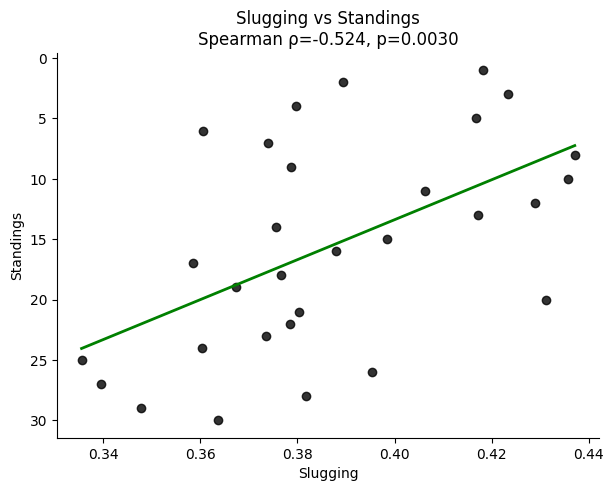

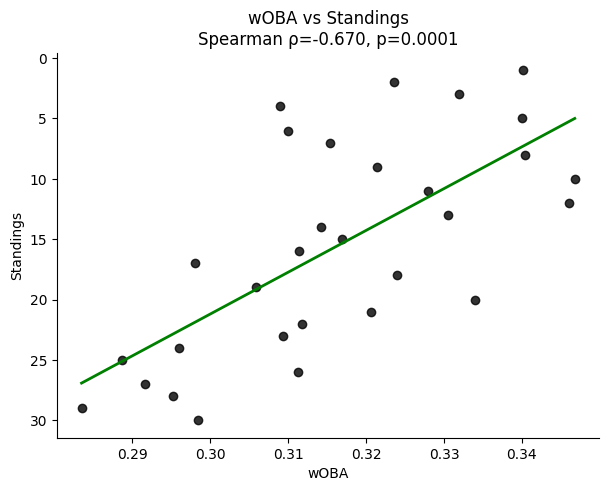

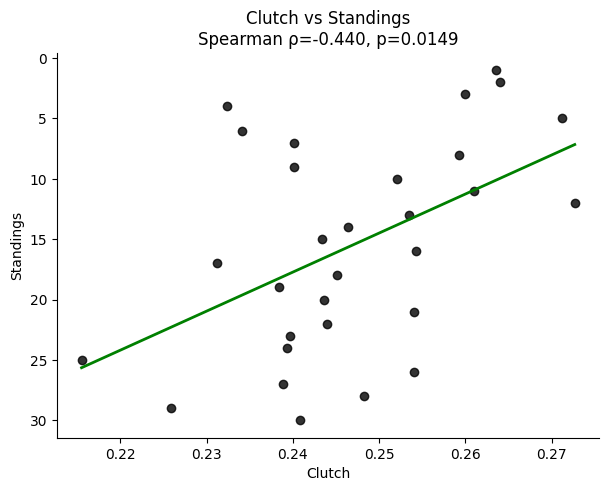

In [44]:
#creating graphs to show correlation and p-value
newplot = clutchBATeam_full.copy()

def plot_spearman(xcol, ycol="Standings"):
    x = newplot[xcol]
    y = newplot[ycol]
    rho, p = spearmanr(x, y)
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 100)
    ys = m * xs + b
    plt.figure(figsize=(7,5))
    plt.scatter(x, y, color = "black" ,alpha=0.8)
    plt.plot(xs, ys, color="green", linewidth=2)  
    for spine in ["top", "right"]:
        plt.gca().spines[spine].set_visible(False)
    plt.title(f"{xcol} vs Standings\nSpearman ρ={rho:.3f}, p={p:.4f}")
    plt.xlabel(xcol)
    plt.ylabel("Standings")
    plt.gca().invert_yaxis()
    plt.grid(False)
    plt.show()

#show all three graphs
plot_spearman("Slugging")
plot_spearman("wOBA")
plot_spearman("Clutch")